In [24]:
import yfinance as yf
import pandas as pd
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [3]:
# Download data
gs = yf.download("AAPL", start="2013-10-01", end="2024-10-30")

[*********************100%***********************]  1 of 1 completed


In [4]:
# Preprocess data
dataset_ex_df = gs.copy()
dataset_ex_df = dataset_ex_df.reset_index()
dataset_ex_df['Date'] = pd.to_datetime(dataset_ex_df['Date'])
dataset_ex_df.set_index('Date', inplace=True)

In [19]:
# Extract the 'Close' column as a Series
close_prices = dataset_ex_df['Close']
decomposition = seasonal_decompose(close_prices, model='multiplicative', period=365)
residual = decomposition.resid
residual = residual.dropna()

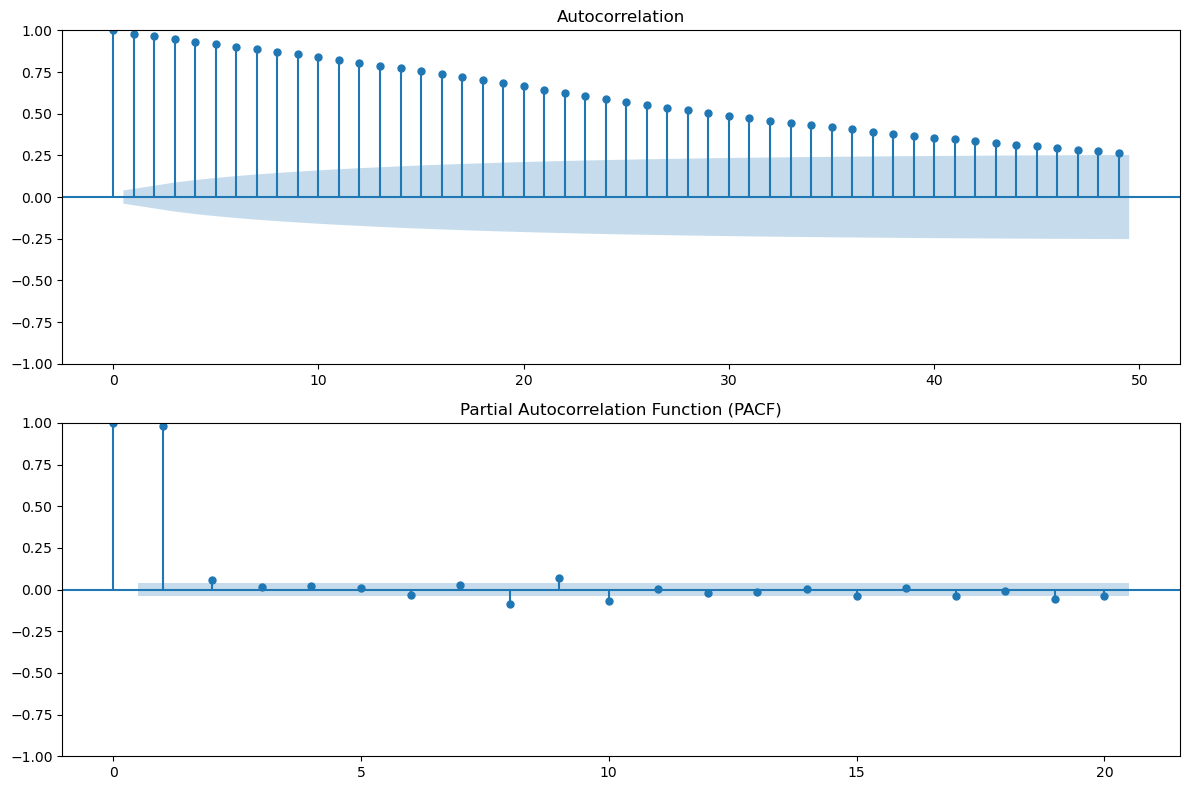

In [29]:
# Create ACF and PACF plots
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Plot the ACF
plot_acf(residual, ax=ax[0], lags=49)
plt.title('Autocorrelation Function (ACF)')

# Plot the PACF
plot_pacf(residual, ax=ax[1], lags=20, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')


# Show the plots
plt.tight_layout()
plt.show()

In [7]:
# Auto ARIMA to select optimal ARIMA parameters
model = auto_arima(residual, seasonal=False, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-13074.548, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6880.277, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3574.271, Time=0.28 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-13077.170, Time=0.36 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=729.933, Time=0.44 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-13077.596, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-13077.989, Time=0.30 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-13073.538, Time=0.46 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-13072.716, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-13098.780, Time=0.59 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-13102.164, Time=0.48 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept

In [30]:
def arima_forecast(history):
    # Ensure history is 1D
    history = np.ravel(history)  # Flatten to 1D
    model = ARIMA(history, order=(49, 0, 0))
    model_fit = model.fit()
    output = model_fit.forecast(steps=1)
    yhat = output[0]
    return yhat

In [10]:
# Split data into train and test sets
train_size = int(len(dataset_ex_df) * 0.8)
train = residual.iloc[:train_size]  # Series
test = residual.iloc[train_size:]  # Series

In [22]:
# Walk-forward validation
history = train.values  # Convert to NumPy array
predictions = []


In [31]:
for t in range(len(test)):
    yhat = arima_forecast(history)  # Forecast the next value
    predictions.append(yhat)
    obs = test.iloc[t]  # Get the actual value
    history = np.append(history, yhat)  # Append as a 1D array


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

In [32]:
# Calculate RMSE
mse_arima = mean_squared_error(test, predictions)
rmse_arima = np.sqrt(mse_arima)
print(f'ARIMA Model - MSE: {mse_arima}, RMSE: {rmse_arima}')

ARIMA Model - MSE: 0.0014228879524374842, RMSE: 0.03772118704968713


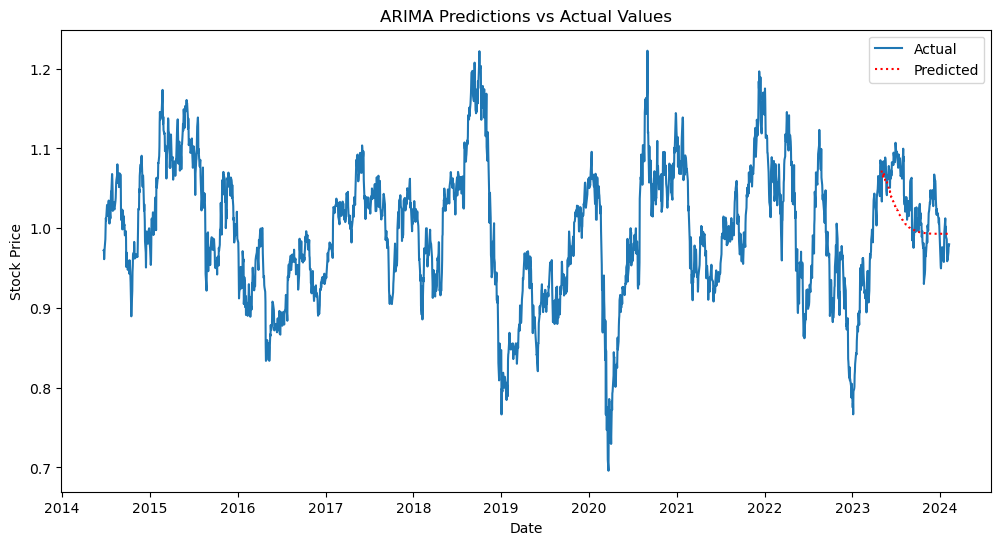

In [33]:
# Plot results
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(residual.index, residual, label='Actual')
plt.plot(test.index, predictions, color='red', linestyle='dotted', label='Predicted')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()